# The App


##### User input locations are located below lines beginning with Input. There are 2 sections where input is required.
##### Output is at bottom after running entire notebook.
##### Version 0.1.


#### Required modules are already installed in:
#### - CoCalc for free cloud usage
#### - Anaconda for local PC/MacOS/Linux
#### - Carnets for iOS
#### - Pydroid3 for Android

#### Now, the program imports them below:

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Wedge
from matplotlib.collections import PatchCollection
from numpy import array, arange, random, cos, sin, pi
random.seed(19) # Useful for reproducible testing.

## Input (Exterior) Rectangle Cut Dimensions:

In [8]:
# Model is created in inches.

rectangle_height = 5*12 #inches
rectangle_width = 9*12 #inches

blue_zone_thickness = 1.25 #inches
green_zone_range = [0.75, 1.50]

emanating_line_length = 3 #inches
emanating_line_thickness = 1/4 #inch

grid_spacing = 12.345 #inches between bars
grid_thickness = 3/16 #inch

tip_length_max = 6 #inches
tip_length_search_precision = 1/16 #inch

origin = (0,0) # Exterior bottom left corner of rectangle blue zone. Recommended to define coordinates from this rectangle corner.

## Input Pin Coordinates and Line Angles:

In [13]:
### Objects:
# For testing only -> object_coordinates = random.random( (60, 2) )*rectangle_width # [(12, 43), (24, 25), (36, 30), (48, 32)]
# For testing only -> object_coordinates = [ (x, y) for x, y in object_coordinates if (x<rectangle_width-emanating_line_length and x>emanating_line_length and y<rectangle_height-emanating_line_length and y>emanating_line_length) ]
object_coordinates = [ (12.3, 33.3), (44.4, 55.5), (24.6, 53.1), (60.0, 20.0), (55.0, 9.5) ] ### (x width, y height) format. Inches from exterior bottom left rectangle corner.

### Put in the pin angles:
# For testing only -> emanating_line_angles = random.random( len(object_coordinates) ) * 360 ### In degrees.
emanating_line_angles = [ 0, 45, 0, 180, 30 ] ### In degrees. 0 degrees is due right.

#### Several functions are defined here:

In [14]:
### Convenient variable; counts # of pins. Nothing to change here.
num_objects = len(object_coordinates)

def thickRectangle(outer_xy, outer_width, outer_height, thickness, color='c', alpha=1):
    ### Create rectangle blue zone.
    ### outer_width = rectangle perimeter outside of rectangle (blue zone)
    ### outer_xy is the (x,y) coordinate of the bottom left corner of the outer rectangle
    outer_xy = array(outer_xy)
    patch_list = []
    section_left = Rectangle( xy=outer_xy, width=thickness, height=outer_height, color=color, lw=None)
    patch_list.append( section_left )
    section_bottom = Rectangle( xy=outer_xy+array([thickness, 0]), width=outer_width-2*thickness, height=thickness, color=color, lw=None )
    patch_list.append( section_bottom )
    section_right = Rectangle( xy=outer_xy+array([outer_width-thickness, 0]), width=thickness, height=outer_height, color=color, lw=None )
    patch_list.append( section_right )
    section_top = Rectangle( xy=outer_xy+array([thickness, outer_height-thickness]), width=outer_width-2*thickness, height=thickness, color=color, lw=None)
    patch_list.append( section_top )
    return PatchCollection(patch_list, alpha=alpha)

def thickGrid(grid_spacing, tip_length_x, tip_length_y, grid_thickness, rectangle_width, rectangle_height):
    ### Makes the grid, and outputs gridline data while we're at it.
    patch_list = []
    ### Vertical gridlines:
    grid_xs = arange(tip_length_x-grid_spacing*6, rectangle_width+1, step=grid_spacing)
    for x in grid_xs:
        patch_list.append( Rectangle( xy=(x-grid_thickness/2, -1), width=grid_thickness, height=rectangle_height+2, color='brown', lw=None ) )
    ### Horizontal gridlines:
    grid_ys = arange(rectangle_height-tip_length_y-grid_spacing*(rectangle_height//grid_spacing + 1), rectangle_height+1, step=grid_spacing)
    for y in grid_ys:
        ### Create gridline patches for model:
        patch_list.append( Rectangle( xy=(-1, y-grid_thickness/2), width=rectangle_width+2, height=grid_thickness, color='brown', lw=None ) )
    return PatchCollection(patch_list, color='brown', alpha=1), grid_xs, grid_ys

def rect(r, theta):
    ### - Theta input is in degrees.
    ### Converts polar coordinates to cartesian coordinates.
    rad = theta*pi/180 # Converts degrees to radians.
    return array([r*cos(rad), r*sin(rad)])

def createEmanatingLines(object_coordinates, green_zone_range, emanating_line_angles, num_objects):
    emanating_lines = []
    for c in range(num_objects):
        p = array(object_coordinates[c])+rect(green_zone_range[0], emanating_line_angles[c])
        q = array(object_coordinates[c])+rect(green_zone_range[1], emanating_line_angles[c])
        emanating_lines.append([p, q])
    return emanating_lines

def allObjects(object_coordinates, green_zone_range, emanating_line_angles, emanating_line_length, emanating_line_thickness, num_objects):
    patch_list = []
    emanating_lines = []
    for c in range(num_objects):
        patch_list.append( Wedge( center=object_coordinates[c], r=green_zone_range[1], theta1=0, theta2=360, width=green_zone_range[1]-green_zone_range[0], lw=None ) )
        p = array(object_coordinates[c])+rect(green_zone_range[0], emanating_line_angles[c])
        q = array(object_coordinates[c])+rect(green_zone_range[1], emanating_line_angles[c])
        emanating_lines.append([p, q])
        #plt.plot( [p[0],q[0]], [p[1],q[1]], color='k' ) ### The 0-width point emanating line.
        patch_list.append( Rectangle( xy=array(object_coordinates[c])+rect(emanating_line_thickness/2, emanating_line_angles[c]-90), width=emanating_line_length, height=emanating_line_thickness, angle=emanating_line_angles[c], color='k', lw=None ) )
    return PatchCollection(patch_list, zorder=10, color='g', alpha=0.5), emanating_lines

def orientation(p, q, r):
    ### Find the orientation of an ordered triplet (p,q,r)
    val = float(q[1]-p[1])*(r[0]-q[0]) - float(q[0]-p[0])*(r[1]-q[1])
    if val > 0:
        return 1 # Clockwise orientation
    elif val < 0:
        return 2 # Counterclockwise orientation
    else:
        return 0 # Colinear orientation

def onSegment(p, q, r):
    ### Used internally in testOverlap for code clarity and speed.
    return ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1])) )    

def testOverlap(p1,q1,p2,q2):
    ### Returns true if the line segment 'p1q1' and 'p2q2' intersect. 
    ### Find the 4 orientations required for the general and special cases:
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
    ### General Case:
    if ((o1 != o2) and (o3 != o4)): 
        return True
    ### Special Cases: 
    ### p1, q1, and p2 are colinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, p2, q1)): 
        return True
    ### p1, q1, and q2 are colinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q2, q1)): 
        return True
    ### p2, q2, and p1 are colinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, p1, q2)): 
        return True
    ### p2, q2, and q1 are colinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q1, q2)): 
        return True
    ### If none of the cases: 
    return False

def countVertices(tx, ty, blue_zone_thickness, grid_spacing, rectangle_height, rectangle_width):
    vertices_in_blue_zone = 0
    if tx < blue_zone_thickness:
        ### Count vertices on left blue zone side:
        vertices_in_blue_zone += (rectangle_height-ty)//grid_spacing
    if ((rectangle_width -blue_zone_thickness-tx)%grid_spacing < blue_zone_thickness):
        ### Count vertices on right blue zone side:
        vertices_in_blue_zone += rectangle_height//grid_spacing
    if ty < blue_zone_thickness:
        ### Count vertices on top blue zone side:
        vertices_in_blue_zone += (rectangle_width -tx)//grid_spacing
    if ((rectangle_height-blue_zone_thickness-ty)%grid_spacing < blue_zone_thickness):
        ### Count vertices on bottom blue zone side:
        vertices_in_blue_zone += rectangle_width //grid_spacing
    return vertices_in_blue_zone

def nearestGridlines(coord, grid_xs, grid_ys):
    ### Gets the nearest gridlines that the pin might intersect / match over.
    x, y = coord
    xdists = [abs(x-v) for v in grid_xs]
    ydists = [abs(y-v) for v in grid_ys]
    closest_verti = grid_xs[xdists.index(min(xdists))]
    closest_horiz = grid_ys[ydists.index(min(ydists))]
    vline = [[closest_verti, -10000], [closest_verti, 10000]]
    hline = [[-10000, closest_horiz], [10000, closest_horiz]]
    return vline, hline

def checkForMatches(object_coordinates, emanating_lines, grid_xs, grid_ys):
    ### Analyze the model to see how many pins intersect a gridline, and save T/F booleans representing which pins intersect and which do not.
    matches = 0
    intersection_booleans = []
    for n in range(num_objects):
        nearest_vertical_gridline, nearest_horizontal_gridline = nearestGridlines(object_coordinates[n], grid_xs, grid_ys)
        bool_here = testOverlap(emanating_lines[n][0], emanating_lines[n][1], nearest_vertical_gridline[0], nearest_vertical_gridline[1]) or testOverlap(emanating_lines[n][0], emanating_lines[n][1], nearest_horizontal_gridline[0], nearest_horizontal_gridline[1])
        intersection_booleans.append(bool_here)
        if bool_here:
            matches += 1
    return matches, intersection_booleans

def generateModel(tip_length_x, tip_length_y, grid_spacing, grid_thickness, blue_zone_thickness, green_zone_range, emanating_line_angles, emanating_line_length, emanating_line_thickness, num_objects, rectangle_width, rectangle_height, origin):
    ### Make the figure:
    fig, ax = plt.subplots( figsize=(15,8), dpi=200 )
    ax.set_aspect('equal')
    
    ### Create the model:
    Grid, grid_xs, grid_ys = thickGrid(grid_spacing, tip_length_x, tip_length_y, grid_thickness, rectangle_width, rectangle_height)
    ax.add_collection( Grid )
    ax.add_collection( thickRectangle(outer_xy=origin, outer_width=rectangle_width, outer_height=rectangle_height, thickness=blue_zone_thickness, color='c', alpha=0.5) )
    Objects, emanating_lines = allObjects(object_coordinates, green_zone_range, emanating_line_angles, emanating_line_length, emanating_line_thickness, num_objects)
    ax.add_collection( Objects )
    
    ### X out pins that do not match a gridline in the green zone over the emanating line:
    intersection_booleans = checkForMatches( object_coordinates, emanating_lines, grid_xs, grid_ys )[1]
    [plt.plot(object_coordinates[n][0], object_coordinates[n][1], color='r', marker="x", markersize=100) for n in range(num_objects) if (intersection_booleans[n]==False)]
    
    ### Make the plot:
    plt.xlim( (-1,rectangle_width +1) )
    plt.ylim( (-1,rectangle_height+1) )
    plt.tight_layout()
    plt.show()

### Now, the program will find the best tip lengths:

Best combos:

Vertices in blue zone = 12 
# Matched = 3 
# Unmatched = 2 
Tip length X = 0.75 
Tip length Y = 0.375


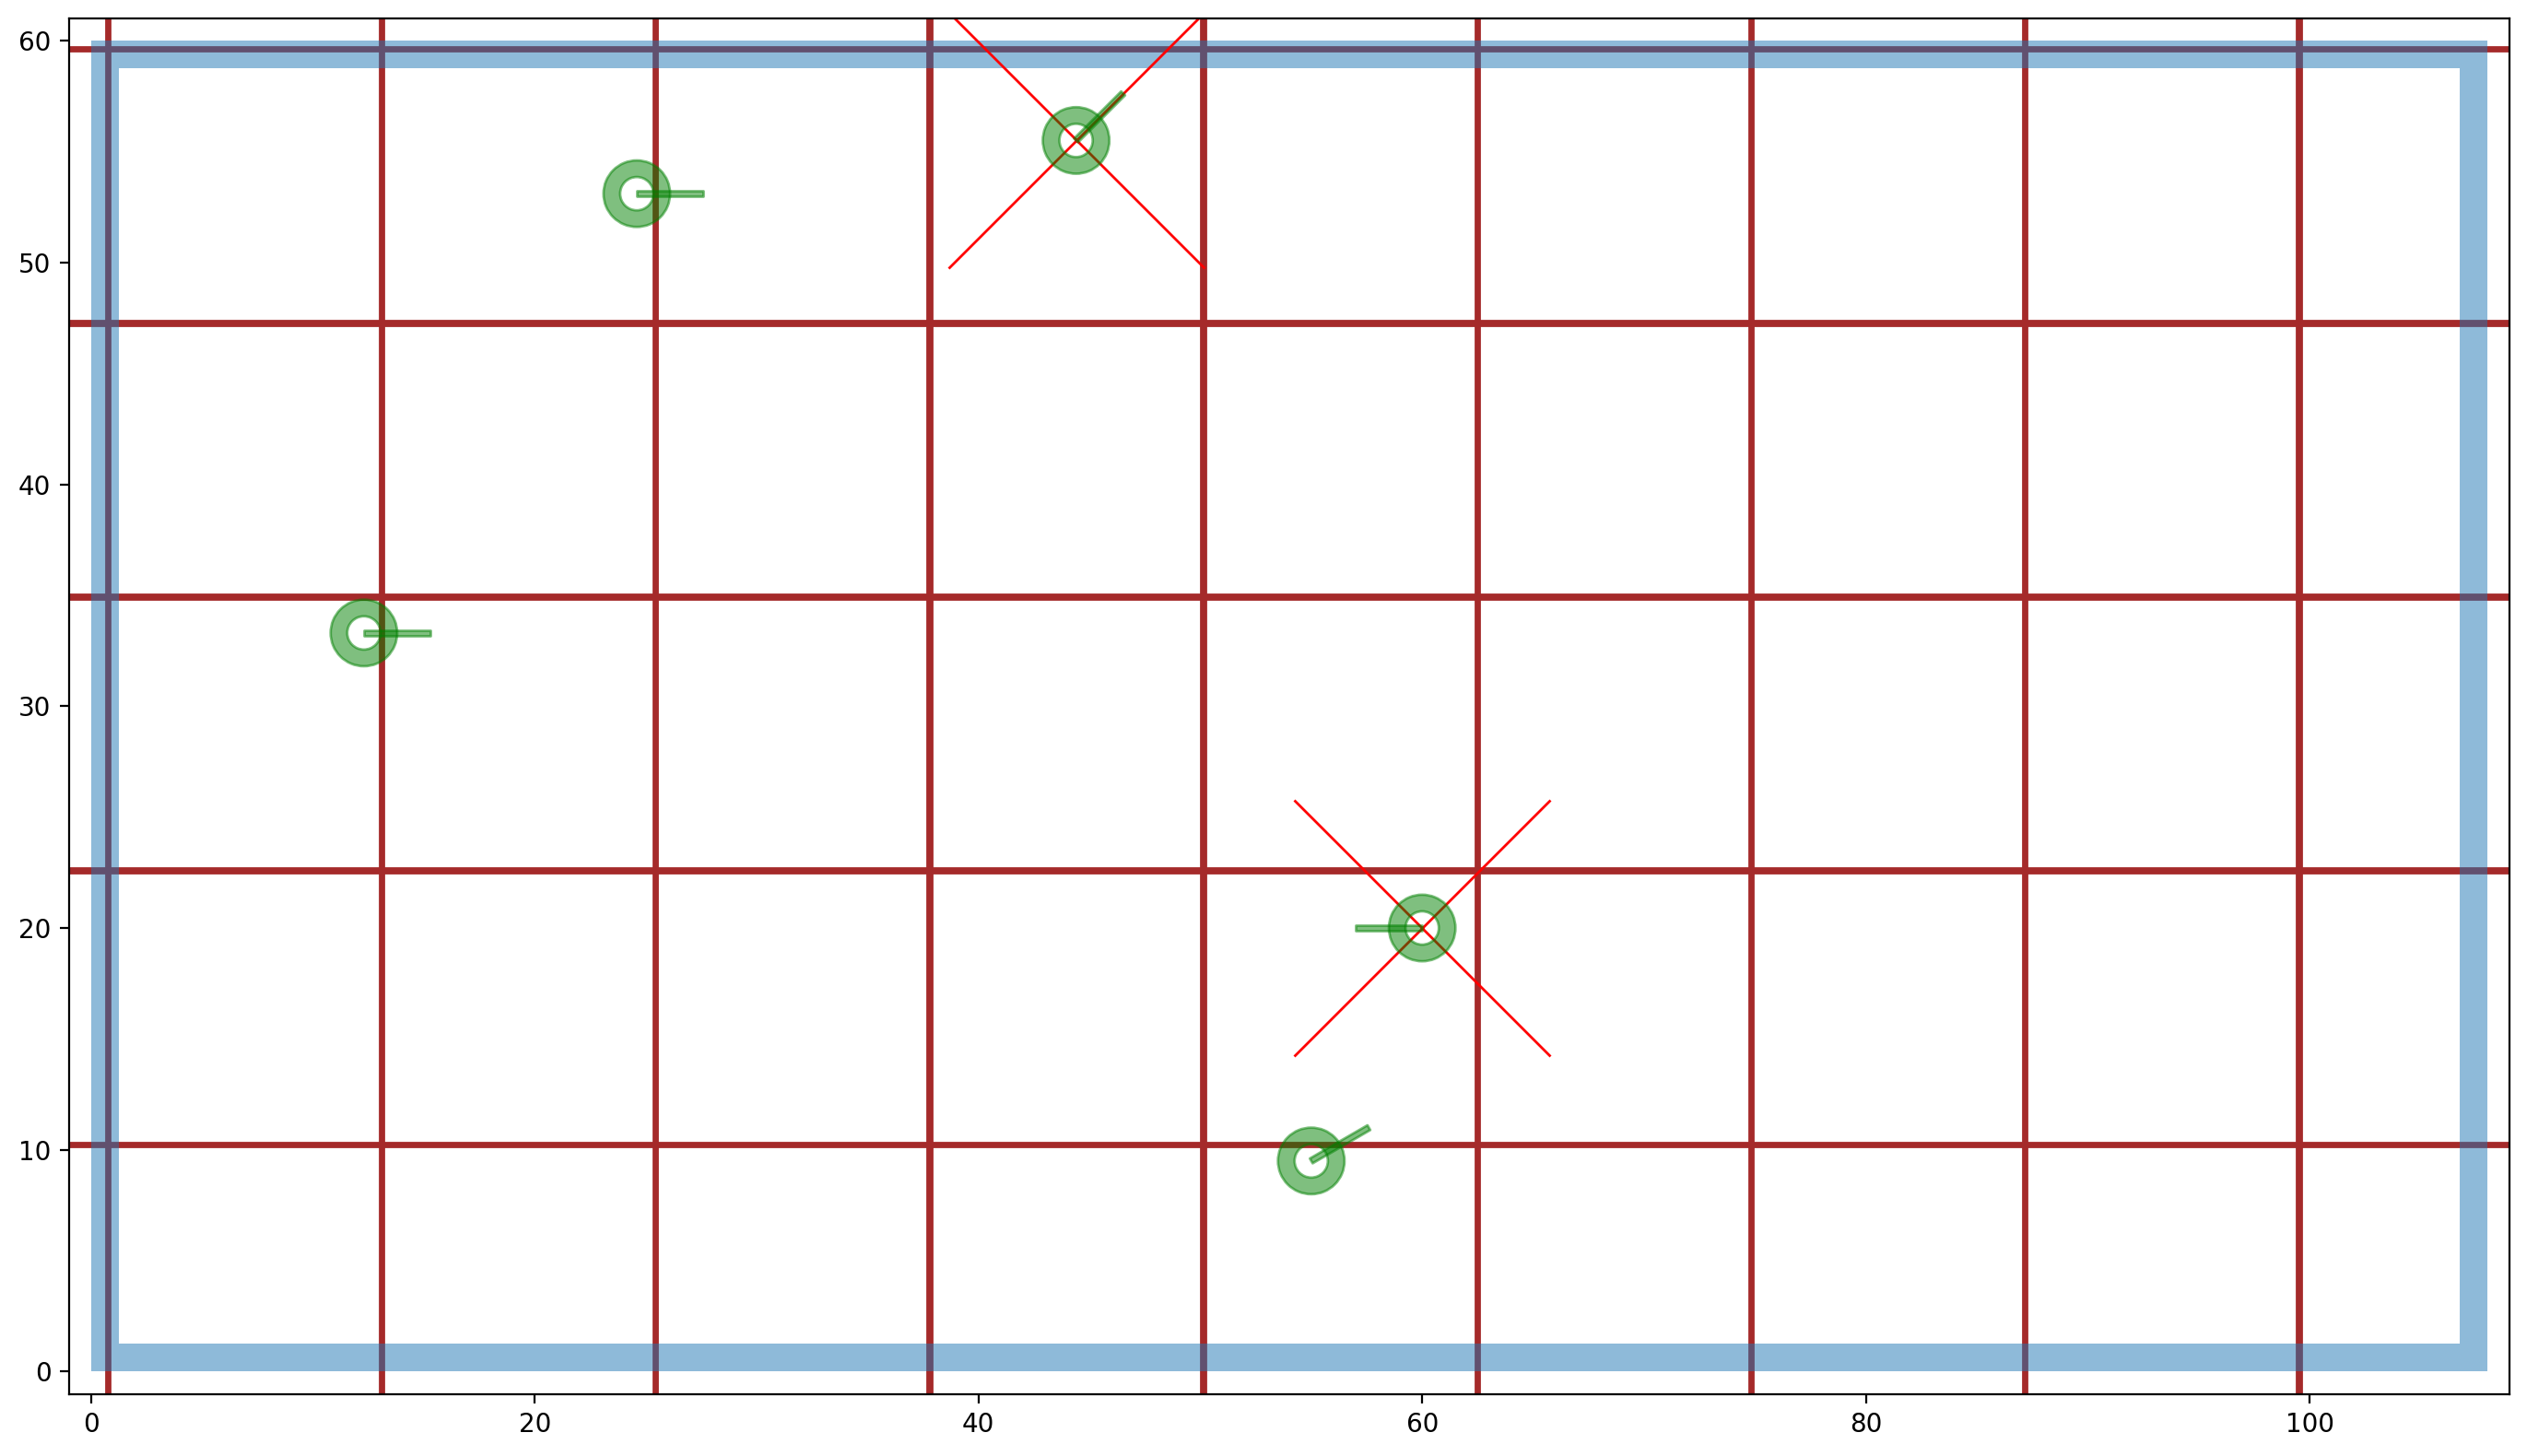

In [15]:
best_combos = [ [0,0,0,0] ]
best_intersection_booleans = []
for tx in arange(0, tip_length_max, step=tip_length_search_precision):
    for ty in arange(0, tip_length_max, step=tip_length_search_precision):
        good_vertices = countVertices(tx, ty, blue_zone_thickness, grid_spacing, rectangle_height, rectangle_width)
        # Now for matches, we need to recreate the grid somewhat, and get the emanating lines:
        grid_xs = arange(tx-grid_spacing*6, rectangle_width+1, step=grid_spacing)
        grid_ys = arange(rectangle_height-ty-grid_spacing*(rectangle_height//grid_spacing + 1), rectangle_height+1, step=grid_spacing)
        emanating_lines = createEmanatingLines(object_coordinates, green_zone_range, emanating_line_angles, num_objects)
        matches, intersection_booleans = checkForMatches(object_coordinates, emanating_lines, grid_xs, grid_ys)
        if matches > 0:
            if all( good_vertices>b[0] for b in best_combos ):
                if all( (matches>b[1]) for b in best_combos ):
                    best_combos = [ [int(good_vertices), matches, tx, ty] ]
                else:
                    best_combos.append( [int(good_vertices), matches, tx, ty] )
                    
            elif (good_vertices==max(b[0] for b in best_combos)) and (matches>max(b[1] for b in best_combos)):
                best_combos = [b for b in best_combos if b[0] != good_vertices] ### Removes the previous best value.
                best_combos.append( [int(good_vertices), matches, tx, ty] )
                
            elif all( matches>b[1] for b in best_combos ):
                best_combos.append( [int(good_vertices), matches, tx, ty] )
            elif (matches==max(b[1] for b in best_combos)) and (good_vertices>next(b[0] for b in best_combos if b[1]==matches)):
                best_combos = [b for b in best_combos if b[1] != matches]
                best_combos.append( [int(good_vertices), matches, tx, ty] )
            # Algorithm Structure :
            # If this combo is the best, it will become the entire best_combos list.
            # Elif this combo has the most vertices, it will definitely be saved.
            # Elif this combo is equal to the most vertices, check if it also has the most matches. If so, delete the lesser.
            # Elif this combo has the most matches, it will definitely be saved.
            # Elif this combo is equal to the most matches, check if it also has *more* vertices than the lesser.
            # Else Do not save it; move on!

            


''' Best Results are printed here... '''

print( "Best combos:" )
[print( "\nVertices in blue zone = {} \n# Matched = {} \n# Unmatched = {} \nTip length X = {} \nTip length Y = {}".format(b[0], b[1], num_objects-b[1], b[2], b[3])) for b in best_combos]



''' With Maximum Matches As The Top Priority: '''

txblue, tyblue = best_combos[0][2:4]



''' With Blue Zone As The Top Priority '''

txmax,  tymax  = best_combos[-1][2:4]



''' Now Plot The Model Results '''

generateModel(txmax, tymax, grid_spacing, grid_thickness, blue_zone_thickness, green_zone_range, emanating_line_angles, emanating_line_length, emanating_line_thickness, num_objects, rectangle_width, rectangle_height, origin)
#generateModel(txblue, tyblue, grid_spacing, grid_thickness, blue_zone_thickness, green_zone_range, emanating_line_angles, emanating_line_length, emanating_line_thickness, num_objects, rectangle_width, rectangle_height, origin)